# Intro

Goal of this notebook: 
- summarise Poisson distribution
- visualisations
- demonstrate maximum likelihood method
- debunking myth: frequency of claim number realisations should be Poisson

- log-link function calculations

Please note that this is a self-contained notebook, not using any of my functions. 

In [20]:
import numpy as np
import pandas as pd
from scipy.special import factorial # for elementwise factorial calc of array

from matplotlib import pyplot as plt
import seaborn as sns

# Poisson Summary

For reference: [wikipedia page](https://en.wikipedia.org/wiki/Poisson_distribution), lots of extra information there (like assumptions, real-life examples, etc.)

__Parameters__: $\lambda \in (0, \infty)$, this is the mean and variance as well  
<br>
__Probability Mass Function__: $Pr(X=k) = \displaystyle \frac{\lambda ^ {k} e ^ {- \lambda}} {k!}$
<br>

The following likelihood functions are the 'standard' approach, so we have observations from one specific distribution. 

__Likelihood__: $L(\lambda, x _{1}, ..., x _{n}) = \displaystyle \prod _{j=1} ^{n} \displaystyle \frac{\lambda ^ {x _{j}} e ^ {- \lambda}} {x _{j} !}$

__Log-likelihood__: $l(\lambda, x _{1}, ..., x _{n}) =  log(L(\lambda, x _{1}, ..., x _{n})) = log(\displaystyle \prod _{j=1} ^{n} \displaystyle \frac{\lambda ^ {x _{j}} e ^ {- \lambda}} {x _{j} !}) = \sum \limits _{j=1} ^{n} log (\displaystyle \frac{\lambda ^ {x _{j}} e ^ {- \lambda}} {x _{j} !}) = $
<br>
$ = log(\lambda) \sum \limits _{j=1} ^{n} x _{j} - n \lambda - \sum \limits _{j=1} ^{n} log(x _{j}!) $

However, in insurance, we basically need to calculate likelihoods row-wise, so there's not much point in writing formulas that assume the same predicted value (a.k.a. lambda). I think it's better to work with this approach, and know that the likelihoods should be multiplied, while the individual log-likelihoods should be summed. 

With that, the functions I am going to use will assume two scalar inputs. 

__Likelihood__: $L(\lambda, k) = \displaystyle \frac{\lambda ^ {k} e ^ {- \lambda}} {k!}$
<br>

__Log-likelihood__: $l(\lambda, k) = log(L(\lambda, k)) = k * log(\lambda) -\lambda - log(k!)$

In [20]:
np.log(3) + np.log(5)

2.70805020110221

In [21]:
np.log(15)

2.70805020110221

In [18]:
def poisson_likelihood(actu, pred):
    # the factorial is from the scipy package
    return (np.power(pred, actu)) * np.exp(-pred) / factorial(actu)

def poisson_loglikelihood(actu, pred):
    return np.log(poisson_likelihood(actu, pred))

def poisson_loglikelihood2(actu, pred):
    # just a demonstration to make sure my formulas work
    return actu * np.log(pred) - pred - np.log(factorial(actu))

In [23]:
poisson_likelihood(2, 0.5) == 0.5 ** 2 * np.exp(-0.5) / np.math.factorial(2)

True

In [24]:
poisson_likelihood(2, 0.5)

0.07581633246407918

In [25]:
poisson_loglikelihood(2, 0.5)

-2.5794415416798357

In [26]:
poisson_loglikelihood2(2, 0.5)

-2.5794415416798357

## Deviance

Testing the formula found here: https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models

More accurately, see the p=1 mean_tweedie_deviance here, because the log needs special care when the actual is 0: https://github.com/scikit-learn/scikit-learn/blob/364c77e04/sklearn/metrics/_regression.py#L1095

In [6]:
from scipy.special import xlogy

In [12]:
def my_poisson_deviance(actu, pred):
    return(2 * (xlogy(actu, actu / pred) - actu + pred))

In [10]:
from sklearn.metrics import mean_poisson_deviance
y_true = [2, 0, 1, 4]
y_pred = [0.5, 0.5, 2., 2.]
mean_poisson_deviance(y_true, y_pred)

1.4260151319598084

In [15]:
my_poisson_deviance(np.array(y_true), np.array(y_pred))

array([2.54517744, 1.        , 0.61370564, 1.54517744])

In [14]:
def my_mean_poisson_deviance(actu, pred):
    return(np.sum(my_poisson_deviance(actu,pred)) / len(actu))

In [16]:
my_mean_poisson_deviance(np.array(y_true), np.array(y_pred))

1.4260151319598084

And now let's check how deviance is derived from likelihood. 

In [17]:
my_poisson_deviance(2,0.5)

2.5451774444795623

In [21]:
-2 * (poisson_loglikelihood(2, 0.5) - poisson_loglikelihood(2,2))

2.5451774444795623

# Generate Data

In [6]:
# variables
lambda1 = 0.85
n1 = 100000

In [7]:
# df1: simple simulated Poisson
df1 = pd.DataFrame.from_dict({'target': np.random.poisson(lambda1, n1)})

In [11]:
# df2: probabilities (likelihoods)
df2 = pd.DataFrame.from_dict({'target' : range(10)})
df2['likelihood'] = poisson_likelihood(df2['target'], lambda1)

# Visualisations

## Simulation

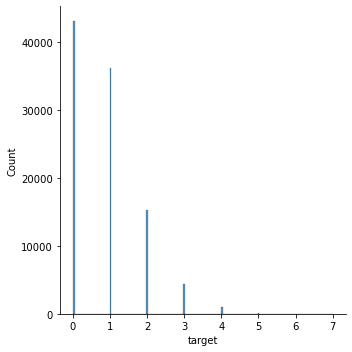

In [9]:
sns.displot(df1['target'])
plt.show()

## Likelihood

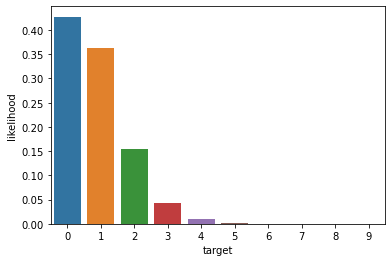

In [10]:
sns.barplot(x = df2['target'], y = df2['likelihood'])
plt.show()

# Maximum Likelihood Demonstration

Goal here: demonstrate that the highest likelihood is achieved with simply taking the average of observations. Meaning the maximum likelihood estimation is also the method of moments for a Poisson distribution. 

Of course, not proving anything, this is just a demonstration. Although the proof is not complicated either. 

__Poisson MLE__: $\hat{\lambda}_{n} = \displaystyle \frac{1} {n} 
\sum \limits _{j=1} ^{n} X_{n}   $

In [15]:
ml1 = pd.DataFrame({'lambda':np.linspace(0.01,1.5,150)})

ml1['poisson_loglikelihood'] = ml1['lambda'].apply(lambda x: np.mean(poisson_loglikelihood(df1['target'], x)))

ml1.sort_values('poisson_loglikelihood')

,lambda,poisson_loglikelihood
0,0.01,-4.126825
1,0.02,-3.550797
2,0.03,-3.217992
3,0.04,-2.984768
4,0.05,-2.806110
...,...,...
86,0.87,-1.211078
82,0.83,-1.210872
85,0.86,-1.210852
83,0.84,-1.210747


In [16]:
np.round(np.mean(df1['target']),2)

0.85

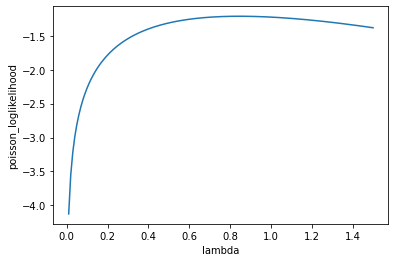

In [18]:
sns.lineplot(x = ml1['lambda'], y = ml1['poisson_loglikelihood'])
plt.show()

# Claim Occurence Table is not Poisson

how often a certain number of claim occurs is not in itself Poisson - it's not adding Poisson numbers

# Log-link Calculations

The canonical link function for a Poisson regression (regardless of whether GLM or GBM) is the logarithm. 

This means that rather than predicting lambda itself, the model estimates a _raw_score_ in a linear fashion from the features, and then the final prediction is the exponential of this _raw_score_. 

This doesn't change the fact that we are maximising the sum of the log-likelihood, just by another format of the same variable. 

## Gradient and Hessian

The gradient and hessian used in the gradient descent methods is the first and second order derivative of the log-likelihood function with respect to the predicted value. The important tweak is that this is the predicted raw score, not the final predicted value. 

First, we have to re-work the log-likelihood function. 

if $\lambda _{raw} = log(\lambda) $, then $\lambda = e ^{\lambda _{raw}}$, and we can re-write the log-likelihood formula: 

$l(\lambda, k) = log(L(\lambda, k)) = k * log(\lambda) -\lambda - log(k!) = k * log(e ^{\lambda _{raw}}) -e ^{\lambda _{raw}} - log(k!) = k * \lambda _{raw} - e ^{\lambda _{raw}} - log(k!)$
<br>
<br>
The gradient is going to be the derivative by $\lambda _{raw}$
<br>
$G(\lambda _{raw}, k) = \displaystyle \frac {d(l(\lambda _{raw}, k))} {d \lambda _{raw}} = k - e ^{\lambda _{raw}} = k - \lambda$
<br>
This is the usual actu - pred result. 
Hessian is one additional derivation, which is going to be simply $\lambda$, so pred. Need to be careful with the signs though!

# TODO

- Make charts nicer, match in style, etc. 
- Demonstrate why claim occurence table is not in itself Poisson. 